In [1]:
import sys
sys.path.append('../')

import os 
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import math

from typing import Mapping, Any, List, Tuple, Optional, Callable
from collections import OrderedDict
from os.path import join as pjoin
from scipy.special import expit
from functools import reduce

import h5py

from os.path import join as pjoin
from glob import glob

from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision.transforms as T
import albumentations as albu

from datasets import RANZCRDataset
from models import CNNModel, CNNSegModel
from utils.inference_utils import avarage_weights, get_validation_models, create_val_loaders, cnn_model_predict, predict_over_all_train
from utils.constants import CLASSES, CLASSES_CHESTX

from matplotlib import pyplot as plt
%matplotlib inline

# Checkpoint

In [2]:
os.listdir('../logdirs/')

['timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs',
 'tf_efficientnet_b5_ns_32bs_640res_qubvelaugs_ls005_shedchanged_smallerler',
 'tf_efficientnet_b5_ns_32bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs',
 'timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_rotaugs_ls005_shedchanged_startpoint_difflrs_segbranch_124coefs_1e4noseg_doublemlp',
 'timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_rotaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg',
 'timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_rotaugs_ls005_shedchanged_mypretrain_difflrs_segbranch_113coefs_1e4noseg_bh',
 'densenet121_unet_52bs_640res_qubvelaugs_rotaugs_ls005_shedchanged_startpoint_difflrs_segbranch_124coefs_1e4noseg',
 'timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_pseudo',
 'timm_efficientnet_b5_pretrain_chestx_16bs_640res_qubvelaugs_rotaugs_ls005_shedchang

In [3]:
exp_name = 'timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_pseudo'
swa_metric = 'roc_auc_score' 
D_M = True
TAKE_BEST = None

folds_to_take = [
    0,
    1,
    2,
    3,
    4
]

target_dir = f'../logdirs/{exp_name}'

In [4]:
chkp_paths = [
    pjoin(target_dir, f'fold_{f}', 'checkpoints/best.pth') for f in folds_to_take
]
chkp_paths

['../logdirs/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_pseudo/fold_0/checkpoints/best.pth',
 '../logdirs/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_pseudo/fold_1/checkpoints/best.pth',
 '../logdirs/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_pseudo/fold_2/checkpoints/best.pth',
 '../logdirs/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_pseudo/fold_3/checkpoints/best.pth',
 '../logdirs/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_pseudo/fold_4/checkpoints/best.pth']

In [5]:
chckps =[
    torch.load(p, map_location='cpu') for p in chkp_paths
]
list(map(lambda x: print(x['valid_metrics']), chckps));

{'roc_auc_score': 0.9482553872019068, 'loss': 0.16421983032809842, 'dice_lung': 0.028391710341006425, 'dice_tube': 0.3800412831047487, 'bce': 0.16421983032809842}
{'roc_auc_score': 0.9555259160337283, 'loss': 0.16072655948833442, 'dice_lung': 0.028011714225977827, 'dice_tube': 0.38999192708760355, 'bce': 0.16072655948833442}
{'roc_auc_score': 0.9489445974038984, 'loss': 0.16018482815386018, 'dice_lung': 0.025762655165528378, 'dice_tube': 0.3840359060974021, 'bce': 0.16018482815386018}
{'roc_auc_score': 0.9520980791136237, 'loss': 0.1553891498522941, 'dice_lung': 0.028621913282143963, 'dice_tube': 0.37990586786227315, 'bce': 0.1553891498522941}
{'roc_auc_score': 0.9563081308712026, 'loss': 0.15547834553827708, 'dice_lung': 0.028544765688924546, 'dice_tube': 0.3811363104470707, 'bce': 0.15547834553827708}


In [6]:
for p in chkp_paths:
    print(p.split('/')[-3])
    print('Best score : {}'.format([(el[0], el[-1]) for el in sorted([v for k,v in torch.load(pjoin(os.path.dirname(p), f'swa_models_{swa_metric}.pt'), map_location='cpu').items()], key=lambda x: -x[0])]))

fold_0
Best score : [(0.9482553872019068, 31), (0.9480191333422251, 25), (0.9461791526003229, 36)]
fold_1
Best score : [(0.9555259160337283, 32), (0.9533108282936106, 29), (0.9531034680747236, 28)]
fold_2
Best score : [(0.9489445974038984, 30), (0.9473754009063672, 25), (0.94715043808116, 21)]
fold_3
Best score : [(0.9520980791136237, 30), (0.9517431800339264, 25), (0.9511253294599805, 32)]
fold_4
Best score : [(0.9563081308712026, 35), (0.9533469591485005, 30), (0.953237872333701, 39)]


In [7]:
if swa_metric is not None:
    chckps =[
        avarage_weights(
            [el[1] for el in sorted([v for k,v in torch.load(pjoin(os.path.dirname(p), f'swa_models_{swa_metric}.pt'), map_location='cpu').items()], key=lambda x: -x[0])],
            delete_module=D_M,
            take_best=TAKE_BEST
        ) for p in chkp_paths
    ] 

# Read data

In [8]:
train = pd.read_csv('/data/additional_data/chestx/train_filtered.csv')

train

Image Index  Patient ID  Patient Age  Patient Gender  View Position  \
0      00000001_000           1     0.659061               0              0   
1      00000001_001           1     0.659061               0              0   
2      00000001_002           1     0.659061               0              0   
3      00000002_000           2     2.024863               0              0   
4      00000003_000           3     2.024863               1              0   
...             ...         ...          ...             ...            ...   
82064  00030801_001       30801    -0.469210               0              0   
82065  00030802_000       30802    -1.063037               0              0   
82066  00030803_000       30803    -0.291062               1              0   
82067  00030804_000       30804    -1.003654               1              0   
82068  00030805_000       30805    -1.181803               0              0   

       Hernia  Atelectasis  Nodule  Effusion  Cardiomegaly  \
0           0            0       0         0             1   
1           0            0       0         0             1   
2           0            0       0         1             1   
3           0            0       0         0             0   
4           1            0       0         0             0   
...       ...          ...     ...       ...           ...   
82064       0            0       0         0             0   
82065       0            0       0         0             0   
82066       0            0       0         0             0   
82067       0            0       0         0             0   
82068       0            0       0         0             0   

       Pleural_Thickening  Consolidation  Emphysema  Mass  Pneumonia  \
0                       0              0          0     0          0   
1                       0              0          1     0          0   
2                       0              0          0     0          0   
3                       0              0          0     0          0   
4                       0              0          0     0          0   
...                   ...            ...        ...   ...        ...   
82064                   0              0          0     1          1   
82065                   0              0          0     0          0   
82066                   0              0          0     0          0   
82067                   0              0          0     0          0   
82068                   0              0          0     0          0   

       Fibrosis  Edema  Pneumothorax  Infiltration  
0             0      0             0             0  
1             0      0             0             0  
2             0      0             0             0  
3             0      0             0             0  
4             0      0             0             0  
...         ...    ...           ...           ...  
82064         0      0             0             0  
82065         0      0             0             0  
82066         0      0             0             0  
82067         0      0             0             0  
82068         0      0             0             0  

[82069 rows x 19 columns]

# Model

In [9]:
DEVICE = 'cuda'

models = get_validation_models(
    model_initilizer=CNNSegModel,
    model_config= {
            "classifiier_config": {
                "classifier_type": "elu",
                "classes_num": 11,
                "hidden_dims": 1024,
                "second_dropout_rate": 0.2,
                "first_dropout_rate": 0.3,
            },
            "encoder_config":{
                "in_channels":3,
                "encoder_name":'timm-efficientnet-b5', 
                "encoder_weights":None, 
                "classes":2, 
                "activation":'sigmoid',
                "aux_params":dict(
                    pooling='avg',             # one of 'avg', 'max'
                    dropout=None,               # dropout ratio, default is None
                    classes=4,                 # define number of output labels
                )
            },
            "encoder_type": "timm-efficientnet-b5_unet",
            "use_taylorsoftmax": False,
            "one_channel": True,
            "enable_inference_mode": True
            #"path_to_chkp": "/data/additional_data/startingpoints/densenet121_chestx.pth",
        },
    model_ckp_dicts=chckps,
    device=DEVICE
)

# Val Predict

In [10]:
def predict_over_all_train(
    my_loaders, my_models, model_predict_func, device, do_concat=True
):
    logits = []
    for loader, model in zip(my_loaders, my_models):
        local_logits = []
        for batch in tqdm(loader):
            logit = model_predict_func(batch, model, device)
            local_logits.append(logit)
        logits.append(np.concatenate(local_logits))

    if do_concat:
        logits = np.stack(logits)

    return logits

In [11]:
ROOT_PATH = '/data/additional_data/chestx/all_images_640_640/'
SKIP_TRANSP_AND_ROT = False

In [ ]:
val_loaders_original = create_val_loaders(
    loader_initilizer=RANZCRDataset,
    loader_config={
           "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
            "transforms":T.ToTensor()
            },
    dfs=[train, train, train, train, train],
    batch_size=32
)

train_logits_original = predict_over_all_train(
    val_loaders_original,
    models,
    cnn_model_predict,
    DEVICE
)
if not SKIP_TRANSP_AND_ROT:
    val_loaders_transp = create_val_loaders(
        loader_initilizer=RANZCRDataset,
        loader_config={
               "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
                "transforms":T.ToTensor(),
                "augmentations": albu.Transpose(p=1.0)
                },
        dfs=[train, train, train, train, train],
        batch_size=32
    )

    train_logits_transp = predict_over_all_train(
        val_loaders_transp,
        models,
        cnn_model_predict,
        DEVICE
    )
    
    val_loaders_transp_hf = create_val_loaders(
        loader_initilizer=RANZCRDataset,
        loader_config={
               "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
                "transforms":T.ToTensor(),
                "augmentations": albu.Compose([albu.Transpose(p=1.0), albu.HorizontalFlip(p=1.0)]) 
                },
        dfs=[train, train, train, train, train],
        batch_size=32
    )

    train_logits_transp_hf = predict_over_all_train(
        val_loaders_transp_hf,
        models,
        cnn_model_predict,
        DEVICE
    )
    
    val_loaders_transp_vf = create_val_loaders(
        loader_initilizer=RANZCRDataset,
        loader_config={
               "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
                "transforms":T.ToTensor(),
                "augmentations": albu.Compose([albu.Transpose(p=1.0), albu.VerticalFlip(p=1.0)])
                },
        dfs=[train, train, train, train, train],
        batch_size=32
    )

    train_logits_transp_vf = predict_over_all_train(
        val_loaders_transp_vf,
        models,
        cnn_model_predict,
        DEVICE
    )

val_loaders_hf = create_val_loaders(
    loader_initilizer=RANZCRDataset,
    loader_config={
           "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
            "transforms":T.ToTensor(),
            "augmentations": albu.HorizontalFlip(p=1.0)
            },
    dfs=[train, train, train, train, train],
    batch_size=32
)

train_logits_hf = predict_over_all_train(
    val_loaders_hf,
    models,
    cnn_model_predict,
    DEVICE
)

val_loaders_vf = create_val_loaders(
    loader_initilizer=RANZCRDataset,
    loader_config={
          "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
            "transforms":T.ToTensor(),
            "augmentations": albu.VerticalFlip(p=1.0)
            },
    dfs=[train, train, train, train, train],
    batch_size=32
)

train_logits_vf = predict_over_all_train(
    val_loaders_vf,
    models,
    cnn_model_predict,
    DEVICE
)

val_loaders_hf_vf = create_val_loaders(
    loader_initilizer=RANZCRDataset,
    loader_config={
           "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
            "transforms":T.ToTensor(),
            "augmentations": albu.Compose([albu.HorizontalFlip(p=1.0), albu.VerticalFlip(p=1.0)])
            },
    dfs=[train, train, train, train, train],
    batch_size=32
)

train_logits_hf_vf = predict_over_all_train(
    val_loaders_hf_vf,
    models,
    cnn_model_predict,
    DEVICE
)

val_loaders_right_rot = create_val_loaders(
    loader_initilizer=RANZCRDataset,
    loader_config={
           "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
            "transforms":T.ToTensor(),
            "augmentations": albu.ShiftScaleRotate(
                            shift_limit=0,
                            scale_limit=0,
                            rotate_limit=(-16,-15),
                            p=1.0
                        )
            },
    dfs=[train, train, train, train, train],
    batch_size=32
)

train_logits_right_rot = predict_over_all_train(
    val_loaders_right_rot,
    models,
    cnn_model_predict,
    DEVICE
)

val_loaders_left_rot = create_val_loaders(
    loader_initilizer=RANZCRDataset,
    loader_config={
           "root": ROOT_PATH,
            "path_col": "Image Index",
            "ext": ".jpeg",
            "target_col": CLASSES_CHESTX,
            "transforms":T.ToTensor(),
            "augmentations": albu.ShiftScaleRotate(
                            shift_limit=0,
                            scale_limit=0,
                            rotate_limit=(15,16),
                            p=1.0
                        )
            },
    dfs=[train, train, train, train, train],
    batch_size=32
)

train_logits_left_rot = predict_over_all_train(
    val_loaders_left_rot,
    models,
    cnn_model_predict,
    DEVICE
)

  5%|▍         | 121/2565 [00:55<18:25,  2.21it/s]

In [13]:
train_logits = np.stack([
    train_logits_original,
    train_logits_hf,
    train_logits_hf_vf,
    train_logits_vf,
    train_logits_transp,
    train_logits_transp_hf,
    train_logits_transp_vf,
    train_logits_right_rot,
    train_logits_left_rot
], axis=0)

train_logits.shape

(9, 5, 82069, 11)

In [14]:
train_probs = expit(train_logits).mean(0).mean(0)

In [21]:
ZERO_CONF = 0.1
ONE_CONF = 0.15

In [22]:
pseudo_mask = reduce(lambda x,y: x&y, [(train_probs[:,i] > 1 - ONE_CONF) | (train_probs[:, i] < ZERO_CONF) for i in range(11)])

In [23]:
pseudo_mask.sum()

17606

# Save arrays

In [24]:
np.savez(
    f'../pseudo/{exp_name}_swa_roc_auc_flips_transp.npz',
    oof_logits=train_logits
)

In [25]:
train_pseudo = train[pseudo_mask].reset_index(drop=True)

In [26]:
train_pseudo[CLASSES] = (train_probs[pseudo_mask] > 0.5).astype(int)

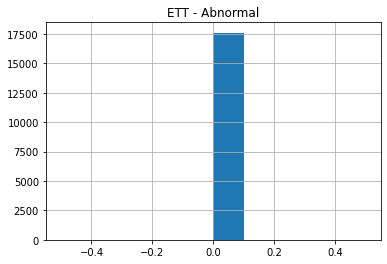

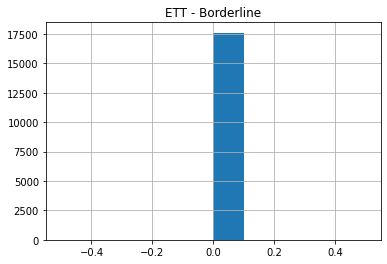

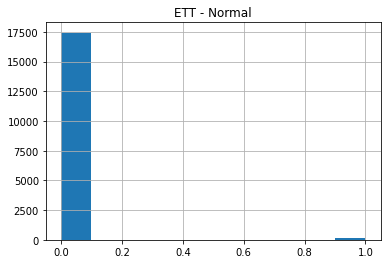

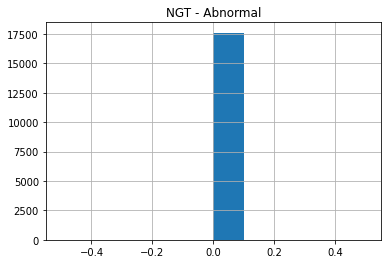

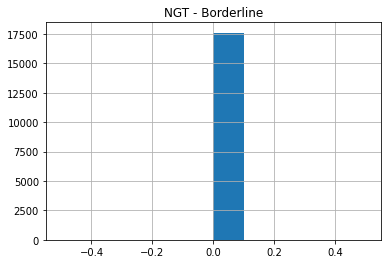

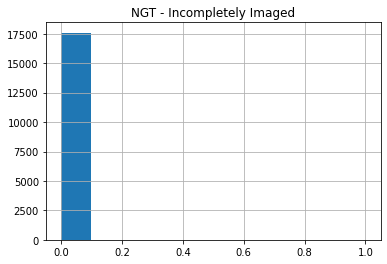

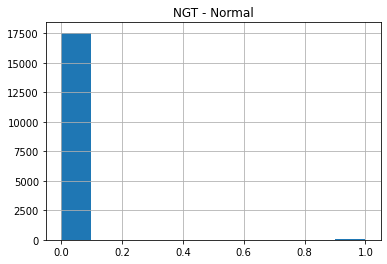

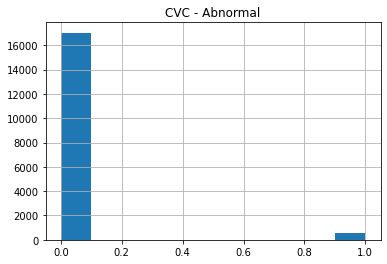

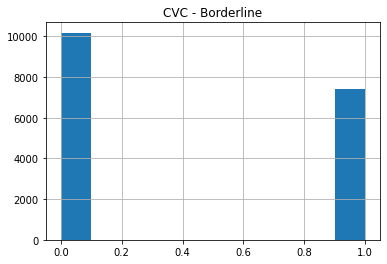

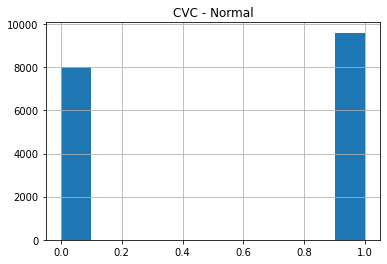

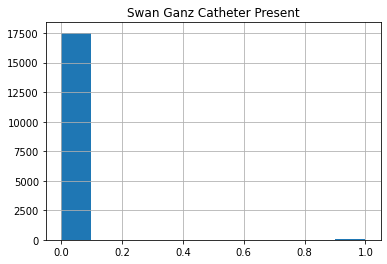

In [27]:
for cls_name in CLASSES:
    plt.title(cls_name)
    train_pseudo[cls_name].hist()
    plt.show()

In [32]:
train_pseudo.to_csv(f'../pseudo/{exp_name}_swa_roc_auc_flips_transp_01_015.csv', index=False)